# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

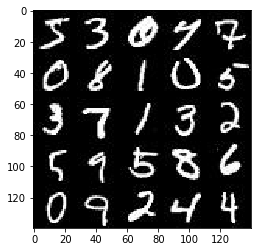

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

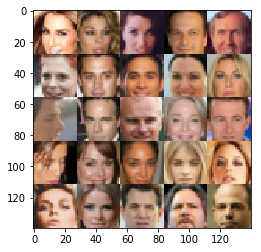

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/akulbei/anaconda/envs/facegen/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_images"), tf.placeholder(tf.float32, (None, z_dim), name="z_data"), tf.placeholder(
        tf.float32, None, name="learning_rate")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.contrib.layers.conv2d(images, 64, 5, stride=2, padding='same')
        x = tf.maximum(alpha * x, x)
        
        x = tf.contrib.layers.conv2d(x, 128, 5, stride=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        x = tf.contrib.layers.conv2d(x, 256, 5, stride=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        
        # flaten
        flat = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        print(x.get_shape())
        
        x = tf.contrib.layers.conv2d_transpose(x, 256, 5, stride=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        print(x.get_shape())
            
        x = tf.contrib.layers.conv2d_transpose(x, 128, 5, stride=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        print(x.get_shape())
        
#         x = tf.contrib.layers.conv2d_transpose(x, 56, 5, stride=2, padding='same')
#         x = tf.layers.batch_normalization(x, training=is_train)
#         x = tf.maximum(alpha * x, x)
#         print(x.get_shape())
        
        # out
        logits = tf.contrib.layers.conv2d_transpose(x, out_channel_dim, 5, stride=2, padding='same')
        out = tf.tanh(logits)
        print(out.get_shape())
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    steps = 0   
    
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                #sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3... Discriminator Loss: 0.2753... Generator Loss: 2.0035
Epoch 1/3... Discriminator Loss: 1.4778... Generator Loss: 5.3933
Epoch 1/3... Discriminator Loss: 1.2666... Generator Loss: 0.7986
Epoch 1/3... Discriminator Loss: 0.8495... Generator Loss: 1.3766
Epoch 1/3... Discriminator Loss: 1.0819... Generator Loss: 0.8319
Epoch 1/3... Discriminator Loss: 1.0041... Generator Loss: 1.6763
Epoch 1/3... Discriminator Loss: 0.9279... Generator Loss: 1.2130
Epoch 1/3... Discriminator Loss: 1.4310... Generator Loss: 0.4047
Epoch 1/3... Discriminator Loss: 1.2310... Generator Loss: 1.5202
Epoch 1/3... Discriminator Loss: 1.1663... Generator Loss: 1.4244


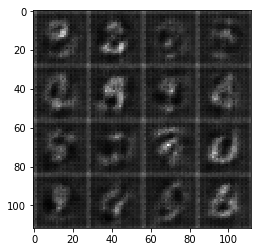

Epoch 1/3... Discriminator Loss: 1.1542... Generator Loss: 1.5897
Epoch 1/3... Discriminator Loss: 1.1746... Generator Loss: 1.5860
Epoch 1/3... Discriminator Loss: 1.1137... Generator Loss: 1.4547
Epoch 1/3... Discriminator Loss: 0.9580... Generator Loss: 1.0854
Epoch 1/3... Discriminator Loss: 1.0633... Generator Loss: 1.2160
Epoch 1/3... Discriminator Loss: 1.2161... Generator Loss: 1.9800
Epoch 1/3... Discriminator Loss: 1.0660... Generator Loss: 0.6225
Epoch 1/3... Discriminator Loss: 0.8957... Generator Loss: 0.8827
Epoch 1/3... Discriminator Loss: 0.8734... Generator Loss: 1.5802
Epoch 1/3... Discriminator Loss: 0.9664... Generator Loss: 0.6573


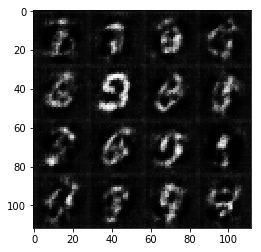

Epoch 1/3... Discriminator Loss: 0.7838... Generator Loss: 1.3238
Epoch 1/3... Discriminator Loss: 0.7347... Generator Loss: 1.7034
Epoch 1/3... Discriminator Loss: 0.9515... Generator Loss: 2.5236
Epoch 2/3... Discriminator Loss: 0.6351... Generator Loss: 1.5255
Epoch 2/3... Discriminator Loss: 0.6526... Generator Loss: 1.5350
Epoch 2/3... Discriminator Loss: 0.9483... Generator Loss: 0.6341
Epoch 2/3... Discriminator Loss: 0.6191... Generator Loss: 1.6298
Epoch 2/3... Discriminator Loss: 0.8946... Generator Loss: 2.6500
Epoch 2/3... Discriminator Loss: 0.5339... Generator Loss: 1.5361
Epoch 2/3... Discriminator Loss: 0.6060... Generator Loss: 1.5799


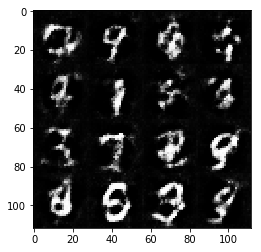

Epoch 2/3... Discriminator Loss: 0.8000... Generator Loss: 0.8244
Epoch 2/3... Discriminator Loss: 0.6353... Generator Loss: 1.7905
Epoch 2/3... Discriminator Loss: 0.6859... Generator Loss: 1.8265
Epoch 2/3... Discriminator Loss: 0.6218... Generator Loss: 1.5923
Epoch 2/3... Discriminator Loss: 0.6971... Generator Loss: 1.9325
Epoch 2/3... Discriminator Loss: 0.6560... Generator Loss: 1.4139
Epoch 2/3... Discriminator Loss: 0.7205... Generator Loss: 1.8932
Epoch 2/3... Discriminator Loss: 1.3370... Generator Loss: 2.9341
Epoch 2/3... Discriminator Loss: 0.9287... Generator Loss: 0.6750
Epoch 2/3... Discriminator Loss: 0.7006... Generator Loss: 1.2386


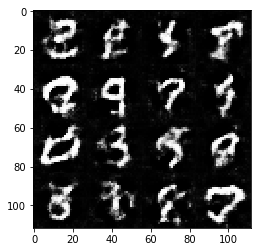

Epoch 2/3... Discriminator Loss: 0.9523... Generator Loss: 2.1550
Epoch 2/3... Discriminator Loss: 0.7391... Generator Loss: 1.0997
Epoch 2/3... Discriminator Loss: 0.6752... Generator Loss: 1.5170
Epoch 2/3... Discriminator Loss: 0.7551... Generator Loss: 1.4451
Epoch 2/3... Discriminator Loss: 1.0844... Generator Loss: 2.4960
Epoch 2/3... Discriminator Loss: 0.7219... Generator Loss: 1.0839
Epoch 3/3... Discriminator Loss: 1.2351... Generator Loss: 0.4331
Epoch 3/3... Discriminator Loss: 0.7888... Generator Loss: 1.8319
Epoch 3/3... Discriminator Loss: 0.7664... Generator Loss: 1.0760
Epoch 3/3... Discriminator Loss: 0.7742... Generator Loss: 1.7643


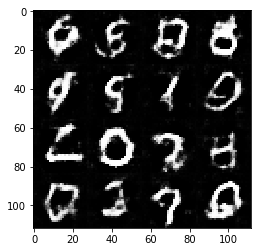

Epoch 3/3... Discriminator Loss: 0.8064... Generator Loss: 1.0581
Epoch 3/3... Discriminator Loss: 0.7132... Generator Loss: 1.4691
Epoch 3/3... Discriminator Loss: 0.9284... Generator Loss: 0.6943
Epoch 3/3... Discriminator Loss: 0.7919... Generator Loss: 0.9164
Epoch 3/3... Discriminator Loss: 0.7881... Generator Loss: 0.8923
Epoch 3/3... Discriminator Loss: 0.9434... Generator Loss: 0.6967
Epoch 3/3... Discriminator Loss: 0.7430... Generator Loss: 1.6576
Epoch 3/3... Discriminator Loss: 0.7553... Generator Loss: 1.0818
Epoch 3/3... Discriminator Loss: 0.7190... Generator Loss: 1.0167
Epoch 3/3... Discriminator Loss: 1.1797... Generator Loss: 2.3181


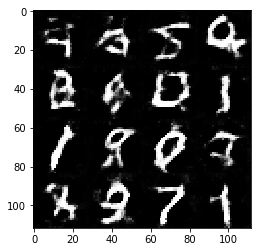

Epoch 3/3... Discriminator Loss: 0.6945... Generator Loss: 1.1508
Epoch 3/3... Discriminator Loss: 0.8109... Generator Loss: 0.8791
Epoch 3/3... Discriminator Loss: 0.6288... Generator Loss: 1.4429
Epoch 3/3... Discriminator Loss: 0.7252... Generator Loss: 1.3225
Epoch 3/3... Discriminator Loss: 0.8503... Generator Loss: 0.7538
Epoch 3/3... Discriminator Loss: 0.6141... Generator Loss: 1.4134
Epoch 3/3... Discriminator Loss: 0.7146... Generator Loss: 0.9867
Epoch 3/3... Discriminator Loss: 2.3820... Generator Loss: 0.1357
Epoch 3/3... Discriminator Loss: 0.8634... Generator Loss: 1.3098
Epoch 3/3... Discriminator Loss: 0.7368... Generator Loss: 1.1765


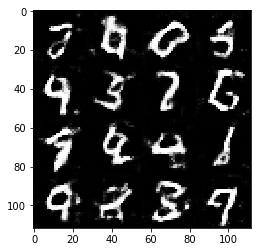

In [31]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 1.3609
Epoch 1/2... Discriminator Loss: 0.4527... Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 0.4982... Generator Loss: 1.6649
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.8309
Epoch 1/2... Discriminator Loss: 1.7773... Generator Loss: 0.2850
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 1.2217
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 1.5181
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.5960


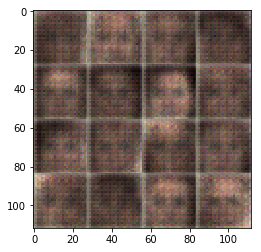

Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.7950
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 1.0984
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 1.6737
Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 1.7095
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.4341
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 1.5227
Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 2.3460


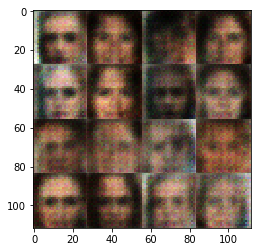

Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 1.3499
Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 2.3504
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 2.2245
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.7194
Epoch 1/2... Discriminator Loss: 0.7374... Generator Loss: 1.5469
Epoch 1/2... Discriminator Loss: 0.7390... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6247


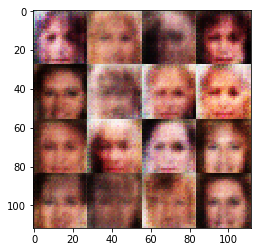

Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.8336
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.2187
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 1.7209
Epoch 1/2... Discriminator Loss: 1.6504... Generator Loss: 0.3442
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 2.0585
Epoch 1/2... Discriminator Loss: 2.2526... Generator Loss: 0.1578
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 0.7022


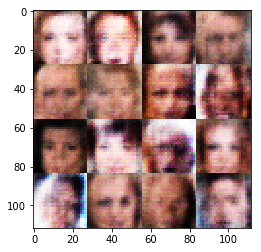

Epoch 1/2... Discriminator Loss: 1.8489... Generator Loss: 2.3167
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 1.3661
Epoch 1/2... Discriminator Loss: 1.6965... Generator Loss: 0.3432
Epoch 1/2... Discriminator Loss: 1.8989... Generator Loss: 0.2210
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 2.4313
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 2.3860
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.3187
Epoch 1/2... Discriminator Loss: 1.0152... Generator Loss: 2.6272
Epoch 1/2... Discriminator Loss: 1.5777... Generator Loss: 0.3459


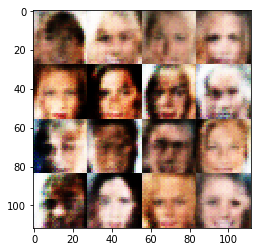

Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.1379
Epoch 1/2... Discriminator Loss: 2.1913... Generator Loss: 0.1524
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 2.8550
Epoch 1/2... Discriminator Loss: 1.5802... Generator Loss: 0.3086
Epoch 1/2... Discriminator Loss: 0.7686... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 2.0128... Generator Loss: 0.1977
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 1.8441
Epoch 1/2... Discriminator Loss: 0.6408... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.4005


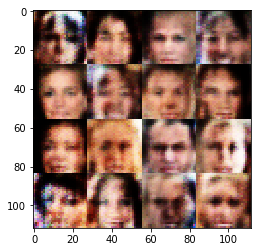

Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 2.6279
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 2.2601
Epoch 1/2... Discriminator Loss: 0.5953... Generator Loss: 1.8747
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 4.2633
Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 2.2073
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 2.4075
Epoch 1/2... Discriminator Loss: 0.8405... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 3.5206
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 2.0247


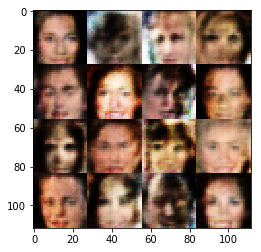

Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 1.2892
Epoch 1/2... Discriminator Loss: 1.8687... Generator Loss: 0.2176
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.0005
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 2.3506
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 1.0199
Epoch 1/2... Discriminator Loss: 0.1872... Generator Loss: 3.1113
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 1.8541
Epoch 2/2... Discriminator Loss: 0.5853... Generator Loss: 1.4871


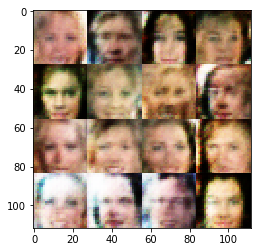

Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 2.9868
Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 0.6208... Generator Loss: 1.5812
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 3.8928
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 4.2235
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.3631
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 5.3714
Epoch 2/2... Discriminator Loss: 0.6026... Generator Loss: 2.7495
Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 0.3568


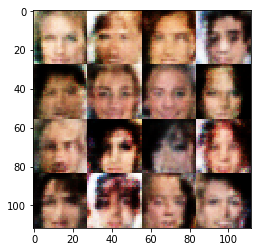

Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.4390
Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 2.0008
Epoch 2/2... Discriminator Loss: 1.4501... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 2.5640... Generator Loss: 0.0954
Epoch 2/2... Discriminator Loss: 1.6939... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 0.4581... Generator Loss: 1.5777
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 0.4238... Generator Loss: 4.5230
Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 0.3568... Generator Loss: 2.3359


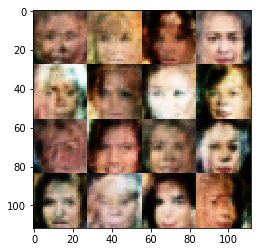

Epoch 2/2... Discriminator Loss: 0.3189... Generator Loss: 3.1969
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 4.7659
Epoch 2/2... Discriminator Loss: 0.3276... Generator Loss: 1.9115
Epoch 2/2... Discriminator Loss: 0.2587... Generator Loss: 4.7018
Epoch 2/2... Discriminator Loss: 1.6467... Generator Loss: 5.1752
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 5.8753
Epoch 2/2... Discriminator Loss: 0.3187... Generator Loss: 2.2091
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 5.3596
Epoch 2/2... Discriminator Loss: 0.2442... Generator Loss: 2.0745
Epoch 2/2... Discriminator Loss: 0.3947... Generator Loss: 3.9204


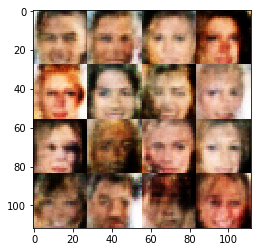

Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 5.4042
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 1.1444
Epoch 2/2... Discriminator Loss: 0.1547... Generator Loss: 6.6472
Epoch 2/2... Discriminator Loss: 2.2290... Generator Loss: 0.1443
Epoch 2/2... Discriminator Loss: 0.3616... Generator Loss: 4.8549
Epoch 2/2... Discriminator Loss: 0.5298... Generator Loss: 6.4647
Epoch 2/2... Discriminator Loss: 0.2864... Generator Loss: 5.7487
Epoch 2/2... Discriminator Loss: 0.4859... Generator Loss: 1.5617
Epoch 2/2... Discriminator Loss: 0.2368... Generator Loss: 3.9714
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 4.8871


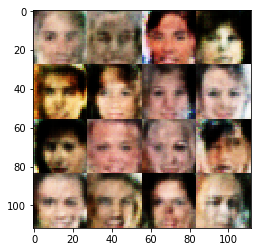

Epoch 2/2... Discriminator Loss: 0.3764... Generator Loss: 1.6146
Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 5.4877
Epoch 2/2... Discriminator Loss: 0.7002... Generator Loss: 1.3803
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.5406
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.2860
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.3755
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 0.2614... Generator Loss: 3.4937
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 6.3228
Epoch 2/2... Discriminator Loss: 0.6257... Generator Loss: 5.6633


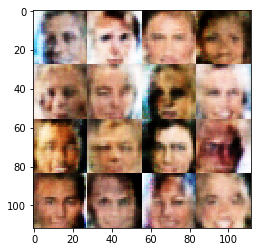

Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 0.2683... Generator Loss: 5.2069
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 4.9217
Epoch 2/2... Discriminator Loss: 0.1821... Generator Loss: 2.6374
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 5.0273
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 5.6087
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 2.4982
Epoch 2/2... Discriminator Loss: 0.3824... Generator Loss: 3.2794
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 2.2228


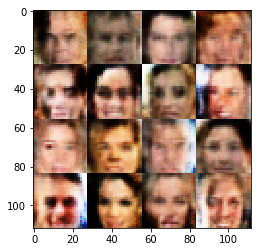

Epoch 2/2... Discriminator Loss: 0.2576... Generator Loss: 2.8835
Epoch 2/2... Discriminator Loss: 0.3687... Generator Loss: 2.2268
Epoch 2/2... Discriminator Loss: 0.2527... Generator Loss: 3.9694
Epoch 2/2... Discriminator Loss: 0.3251... Generator Loss: 2.5890
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 3.6444
Epoch 2/2... Discriminator Loss: 0.3101... Generator Loss: 2.3352
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 4.4218
Epoch 2/2... Discriminator Loss: 1.6789... Generator Loss: 0.2880
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 2.8788


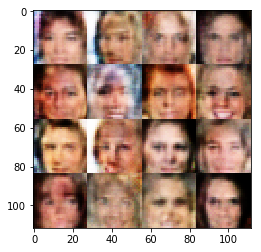

Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 1.9362
Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 1.3290
Epoch 2/2... Discriminator Loss: 0.5410... Generator Loss: 1.5428
Epoch 2/2... Discriminator Loss: 0.4424... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 0.2974... Generator Loss: 2.4315
Epoch 2/2... Discriminator Loss: 0.2717... Generator Loss: 3.4206
Epoch 2/2... Discriminator Loss: 0.4934... Generator Loss: 2.6732
Epoch 2/2... Discriminator Loss: 0.2777... Generator Loss: 5.4694


In [32]:
batch_size = 256
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.